## Analysis of EVI Negative Trend Break Magnitudes with XGBRegressor - Method 2

Peter R., 2023-08-01

### Intro
There are several way to carry our Extreme Gradient Boosting. You could use R or Python.  There are several R packages to do so such as "dismo" and "xgboosting". In Python there are several ways as well. You can do XGB with the sklearn framework and within this framework you can use "xgboost"  train(), XGBClassifier(), XGBRegressor() etc.  Here I use XGBRegression().

Here I try to answer the question: What factors predict EVI Negative Trend Break magnitude?

Note that in this test data sets I do have values for driver which have been assigned by spatio-temporal matches with remote sensing derived disturbance data. I only have data for three drivers: fire, harvest, & insects.  The driver data in the full data set is not reliable as most zeroes are in fact nulls as I was not able to match most of the EVI breaks with disturbance data.  An important missing driver is likely tree windthrow.

#### File and folder path settings

In [1]:
# Import the os module
import os

# Get the current working directory
cwd = os.getcwd()

print(cwd)

C:\Users\Peter R\github\forc_trends\models\xgboost


#### Load and explore the data

In [2]:
import pandas as pd
#from pandas import read_csv

df1 = pd.read_csv(r'.\data\forest_drivers1.csv')
df1.head()


,magnitude,age,deciduous,conifers,protected,elevation,precipitation,temperature,driver_class
0,-765,56.42,24.7,74.8,0,373,813,4.40,0
1,-432,34.42,22.7,76.7,0,374,813,4.40,0
2,-614,53.18,18.5,78.8,0,380,1018,5.06,0
3,-276,72.76,70.2,29.5,0,454,998,4.22,0
4,-291,88.82,29.7,30.7,0,167,819,6.90,0


In [3]:
# note: in this test data set, protected has a single value. Hence, get_dummies does not work as expected
df2 = pd.get_dummies(df1, columns=['protected', 'driver_class'], dtype=float)

df2.head()


,magnitude,age,deciduous,conifers,elevation,precipitation,temperature,protected_0,driver_class_0,driver_class_1,driver_class_2
0,-765,56.42,24.7,74.8,373,813,4.40,1.0,1.0,0.0,0.0
1,-432,34.42,22.7,76.7,374,813,4.40,1.0,1.0,0.0,0.0
2,-614,53.18,18.5,78.8,380,1018,5.06,1.0,1.0,0.0,0.0
3,-276,72.76,70.2,29.5,454,998,4.22,1.0,1.0,0.0,0.0
4,-291,88.82,29.7,30.7,167,819,6.90,1.0,1.0,0.0,0.0


In [4]:
#df2.tail()

In [5]:
# split data into input and output columns
from numpy import absolute

X1 = df2.iloc[:,1:11]
print(X1.head())


     age  deciduous  conifers  elevation  precipitation  temperature  \
0  56.42       24.7      74.8        373            813         4.40   
1  34.42       22.7      76.7        374            813         4.40   
2  53.18       18.5      78.8        380           1018         5.06   
3  72.76       70.2      29.5        454            998         4.22   
4  88.82       29.7      30.7        167            819         6.90   

   protected_0  driver_class_0  driver_class_1  driver_class_2  
0          1.0             1.0             0.0             0.0  
1          1.0             1.0             0.0             0.0  
2          1.0             1.0             0.0             0.0  
3          1.0             1.0             0.0             0.0  
4          1.0             1.0             0.0             0.0  


In [6]:
y1 = df2.iloc[:,0]
print("Response/label data")
#print(y1.head())

print("Response/label data, Absolute value of Negative break magnitude")
y2 = absolute(y1)
print(y2.head())

#X, y = df2[:, :-1], df2[:, -1]
#X.head()

Response/label data
Response/label data, Absolute value of Negative break magnitude
0    765
1    432
2    614
3    276
4    291
Name: magnitude, dtype: int64


#### Set up & run model

Here the model evaluation metric is mean absoulte error. Other metrics are available for regression.


In [7]:
# evaluate an xgboost regression model on the housing dataset
import xgboost as xgb
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split

print("XGB version:", xgb.__version__)

# split data into input and output columns
#X, y = df2[:, :-1], df2[:, -1]

seed = 7 # random seed to help with replication
testsize1 = 0.2 # percent of records to test after training

# Split data set. Note the 'stratify' option
x1_train, x1_test, y1_train, y1_test = train_test_split(X1, y2, test_size=testsize1, random_state=seed)

# set custom parameters rather than use defaults
# 'reg:linear', reg:squarederror
param = {
    'max_depth': 4,
    'eta':0.3,
    'objective': 'reg:squarederror',
   
}

epochs = 10


# define model
model_m2a = XGBRegressor(set_params=param)

# n_estimators is the number of trees
print(model_m2a)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) ) # 289.996 (52.529), Mean MAE: 288.345 (51.031)

XGB version: 1.7.6
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
Mean MAE: 288.345 (51.031)


In [8]:
# evaluate model with mean square error
scores2 = cross_val_score(model_m2a, x1_train, y1_train, scoring='neg_mean_squared_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores2 = absolute(scores)
print('Mean MSE: %.3f (%.3f)' % (scores2.mean(), scores2.std()) ) # Mean MSE: 289.996 (52.529)


Mean MSE: 288.345 (51.031)


In [9]:
#import statistics

# evaluate model with variance explained
scores3 = cross_val_score(model_m2a, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365)

Mean Var. Explained: 0.102 (0.466)


#### Fine tunning parameters
Fine tune parameters to find a better model (potentially). 

In [10]:
# Fine tune parameters using GridSearchCV (for exhaustive searches) or RandomizedSearchCV (faster)

# Take 1
from sklearn.model_selection import RandomizedSearchCV

#search space
params_xgboost = {
 #"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "learning_rate"    : [ 0.05, 0.10, 0.15],
 #"max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_depth"        : [ 3, 4, 5,],
 #"min_child_weight" : [ 1, 3, 5, 7 ],
 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 "gamma"            : [ 0.0, 0.25 , 1.0 ],
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
 'objective': ['reg:squarederror']
}

model_m2b = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_m2b, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=1, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train), 

random_search.best_estimator_



C:\Users\Peter R\.conda\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 27 is smaller than n_iter=100. Running 27 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 27 candidates, totalling 135 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [34]:
# Optimal model according to random search above
model_m2c = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)


#print(model_m2c)

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2c, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 287.413 (49.917)


In [11]:
# evaluate model with variance explained
scores3 = cross_val_score(model_m2c, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365)

Mean Var. Explained: 0.145 (0.423)


In [16]:
# Take 2
# Given that learning_rate and max_depth were at the their upper limit I ran RandomizedSearchCV with expanded values
from sklearn.model_selection import RandomizedSearchCV

#search space
params_xgboost = {
 #"learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "learning_rate"    : [ 0.15, 0.20, 0.25],
 #"max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
 "max_depth"        : [ 5, 6, 8],
 #"min_child_weight" : [ 1, 3, 5, 7 ],
 #"gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 #"gamma"            : [ 0.0, 0.25 , 1.0 ], # 0.25 was chosen
 "gamma"            : [ 0.25], # 0.25 was chosen
 #"colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7],
 #'n_estimators'     : [5, 10, 15, 20, 25, 30, 35],
 'objective': ['reg:squarederror']
}

model_m2d = XGBRegressor()

random_search = RandomizedSearchCV(estimator = model_m2d, 
                      param_distributions = params_xgboost, 
                      n_iter = 100, 
                      cv = 5, 
                      verbose=1, 
                      random_state=42,
                      scoring = 'neg_mean_squared_error', 
                      n_jobs = -1)

#params glare proba
random_search.fit(x1_train, y1_train)

random_search.best_estimator_

C:\Users\Peter R\.conda\envs\xgboost1\lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 9 is smaller than n_iter=100. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 9 candidates, totalling 45 fits


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [17]:
# Optimal model according to random search
model_m2e = XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.2, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None)


# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=seed)

# evaluate model
# -1 means using all processors in parallel
# cross val takes place withing the train data set
scores = cross_val_score(model_m2e, x1_train, y1_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# force scores to be positive
scores = absolute(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 284.639 (44.250)


In [18]:
# evaluate model with variance explained
scores3 = cross_val_score(model_m2e, x1_train, y1_train, scoring='explained_variance', cv=cv, n_jobs=-1)
#print(scores3)

# force scores to be positive
#print(statistics.mean(scores3))
print('Mean Var. Explained: %.3f (%.3f)' % (scores3.mean(), scores3.std()) ) # Mean Var. Explained: 0.076 (0.365)
# Variance explained is less than model_m2c. Model_m2c might be better.

Mean Var. Explained: 0.119 (0.380)


#### Evaluation

In [38]:
from matplotlib import pyplot

eval_set = [(x1_train, y1_train), (x1_test, y1_test)]
model_m2c.fit(x1_train, y1_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True)
# make predictions for test data
y_pred = model_m2c.predict(x1_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
#accuracy = accuracy_score(y1_test, predictions)
#print("Accuracy: %.2f%%" % (accuracy * 100.0))
# retrieve performance metrics
results = model_m2c.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)


[0]	validation_0-error:-948.76259	validation_0-logloss:-39658.53355	validation_1-error:-929.97143	validation_1-logloss:-38850.09548
[1]	validation_0-error:-948.76259	validation_0-logloss:-40244.18009	validation_1-error:-929.97143	validation_1-logloss:-39407.91110
[2]	validation_0-error:-948.76259	validation_0-logloss:-40561.76711	validation_1-error:-929.97143	validation_1-logloss:-39701.28175
[3]	validation_0-error:-948.76259	validation_0-logloss:-40767.00922	validation_1-error:-929.97143	validation_1-logloss:-39905.63463
[4]	validation_0-error:-948.76259	validation_0-logloss:-40919.46134	validation_1-error:-929.97143	validation_1-logloss:-40068.55896
[5]	validation_0-error:-948.76259	validation_0-logloss:-41030.51027	validation_1-error:-929.97143	validation_1-logloss:-40172.54609
[6]	validation_0-error:-948.76259	validation_0-logloss:-41116.77830	validation_1-error:-929.97143	validation_1-logloss:-40257.79361
[7]	validation_0-error:-948.76259	validation_0-logloss:-41185.59822	validati

[62]	validation_0-error:-948.76259	validation_0-logloss:-41543.19811	validation_1-error:-929.97143	validation_1-logloss:-40645.10338
[63]	validation_0-error:-948.76259	validation_0-logloss:-41543.36008	validation_1-error:-929.97143	validation_1-logloss:-40644.83823
[64]	validation_0-error:-948.76259	validation_0-logloss:-41543.45678	validation_1-error:-929.97143	validation_1-logloss:-40644.56710
[65]	validation_0-error:-948.76259	validation_0-logloss:-41543.59148	validation_1-error:-929.97143	validation_1-logloss:-40644.12313
[66]	validation_0-error:-948.76259	validation_0-logloss:-41543.69464	validation_1-error:-929.97143	validation_1-logloss:-40644.14855
[67]	validation_0-error:-948.76259	validation_0-logloss:-41543.78901	validation_1-error:-929.97143	validation_1-logloss:-40645.42439
[68]	validation_0-error:-948.76259	validation_0-logloss:-41543.76667	validation_1-error:-929.97143	validation_1-logloss:-40645.38384
[69]	validation_0-error:-948.76259	validation_0-logloss:-41543.81604	

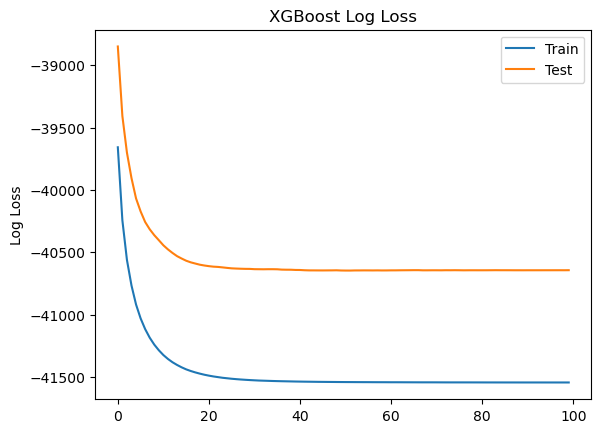

In [39]:
# plot log loss
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('XGBoost Log Loss')
pyplot.show()

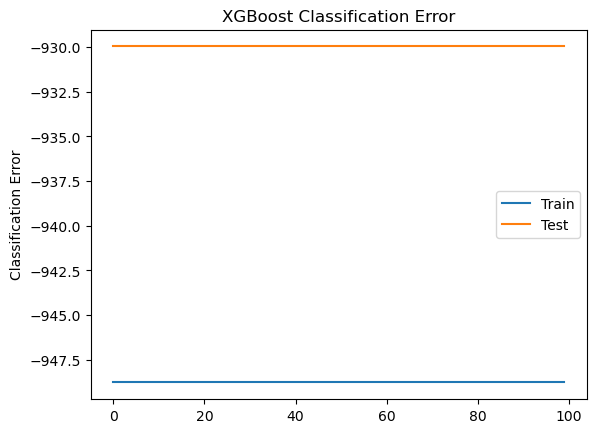

In [40]:
# plot classification error
fig, ax = pyplot.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('XGBoost Regression Error')
pyplot.show()

In [42]:
# implemenmting early stopping to avoid overfitting

model_m2c.fit(x1_train, y1_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=True)


[0]	validation_0-logloss:-39658.53355	validation_1-logloss:-38850.09548
[1]	validation_0-logloss:-40244.18009	validation_1-logloss:-39407.91110
[2]	validation_0-logloss:-40561.76711	validation_1-logloss:-39701.28175
[3]	validation_0-logloss:-40767.00922	validation_1-logloss:-39905.63463
[4]	validation_0-logloss:-40919.46134	validation_1-logloss:-40068.55896
[5]	validation_0-logloss:-41030.51027	validation_1-logloss:-40172.54609
[6]	validation_0-logloss:-41116.77830	validation_1-logloss:-40257.79361
[7]	validation_0-logloss:-41185.59822	validation_1-logloss:-40316.12324
[8]	validation_0-logloss:-41241.18222	validation_1-logloss:-40363.42994
[9]	validation_0-logloss:-41286.46260	validation_1-logloss:-40403.68371
[10]	validation_0-logloss:-41324.89653	validation_1-logloss:-40444.68828
[11]	validation_0-logloss:-41356.21005	validation_1-logloss:-40477.46967
[12]	validation_0-logloss:-41382.55444	validation_1-logloss:-40505.95770
[13]	validation_0-logloss:-41404.29409	validation_1-logloss:-

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.25, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.15, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Predictions
Now let's see how well the models can predict when given new data.

In [44]:
# fit a final xgboost model on the housing dataset and make a prediction
from numpy import asarray

# define model
#model = XGBRegressor()

# fit model
model_m2c.fit(X1, y2, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False) # early_stopping_rounds=10

# define new data
row = [63.0, 16.5, 68.8, 0, 360, 1008, 1.0, 1.0, 0.0, 0.0]
new_data = asarray([row])

# make a prediction
yhat = model_m2c.predict(new_data)

# summarize prediction
print('Predicted: %.3f' % yhat) # Predicted: 532.376, 574.485

Predicted: 576.899


In [45]:
# Predict using test data set

from sklearn.metrics import mean_squared_error

model_m2c.fit(x1_train, y1_train, early_stopping_rounds=10, eval_metric="logloss", eval_set=eval_set, verbose=False)

ypred = model_m2c.predict(x1_test)
mse = mean_squared_error(y1_test, ypred)
print("MSE: %.2f" % mse)

print("RMSE: %.2f" % (mse**(1/2.0)))

#MSE: 243906.16
#RMSE: 493.87

# with model_m2e
#MSE: 224776.87
#RMSE: 474.11

# wimt model_m2c
#MSE: 242319.39
#RMSE: 492.26



MSE: 237606.80
RMSE: 487.45


#### Model accuracy

Given that there are no classes when running regression algoriths, you shouldn't calculate accuracy metrics as when using classification algorithms. Instead, you should calculate errors like mean squared error. (see Jason B. reference)

#### Model plots

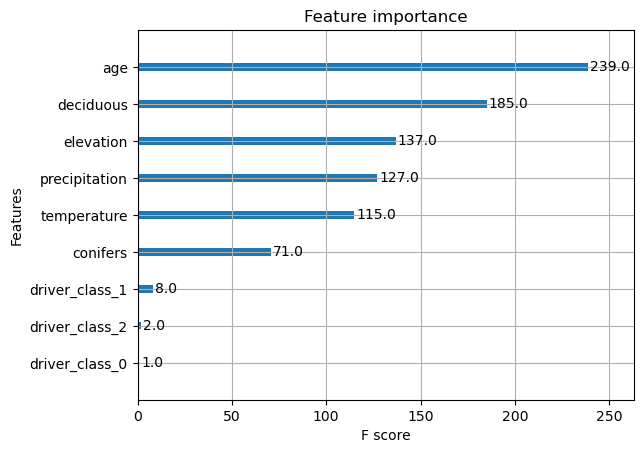

In [104]:
# Plot, metric: weight
#import xgboost as xgb
import matplotlib.pyplot as plt

#xgb.plot_importance(model_m2c, max_num_features=10) # metric=weight is the default
#plt.show()

xgb.plot_importance(model_m2c, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='weight', max_num_features=10, grid=True, show_values=True)

plt.show()

#‘weight’: the number of times a feature is used to split the data across all trees.
# weight: is the percentage representing the relative number of times a particular feature occurs in the trees of the model
# less indicative of the predictive contribution of a feature for the whole model.
# binary feature score low with weight but high with gain and coverage

#‘gain’: the average gain across all splits the feature is used in.
# gain: Gain' is the improvement in accuracy brought by a feature to the branches it is on. Higher value the more important
# The Gain is the most relevant attribute to interpret the relative importance of each feature.
# ‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. 

#‘cover’: the average coverage across all splits the feature is used in.
# cover: The Coverage metric means the relative number of observations related to this feature. Observation-level scope

#‘total_gain’: the total gain across all splits the feature is used in.

#‘total_cover’: the total coverage across all splits the feature is used in.



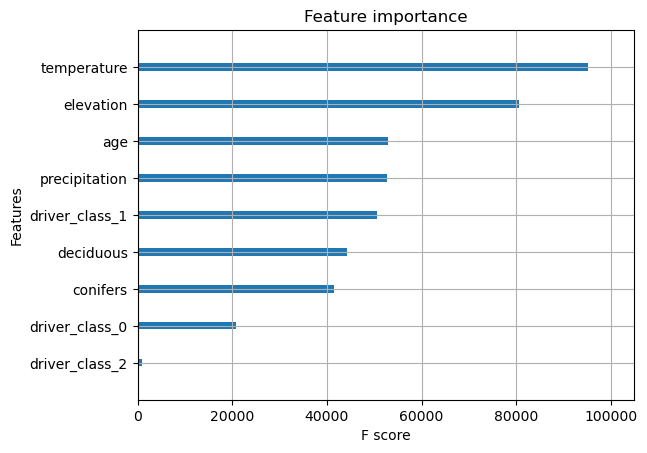

In [105]:
# Plot, metric: gain
xgb.plot_importance(model_m2c, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='gain', max_num_features=10, grid=True, show_values=False) #, values_format='{v:.2f}' )

plt.show()

In [96]:
# Alternate way of plotting
# Plot, metric: weight
#feature_importance_weight = model_m2c.get_booster().get_score(importance_type='weight')
#keys = list(feature_importance_weight.keys())
#values = list(feature_importance_weight.values())

#data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
#data.nlargest(40, columns="score").plot(kind='barh', figsize = (10,5)) ## plot top 40 features

#data.head()


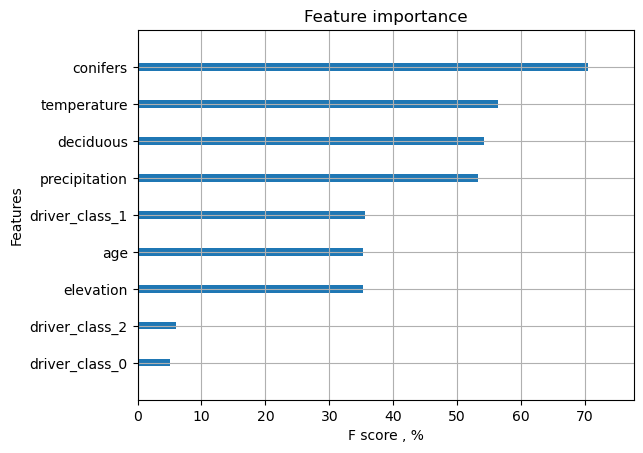

In [106]:
# Plot, metric: cover
xgb.plot_importance(model_m2c, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance', 
                    xlabel='F score , %', ylabel='Features', 
                    importance_type='cover', max_num_features=10, grid=True, show_values=False)

plt.show()


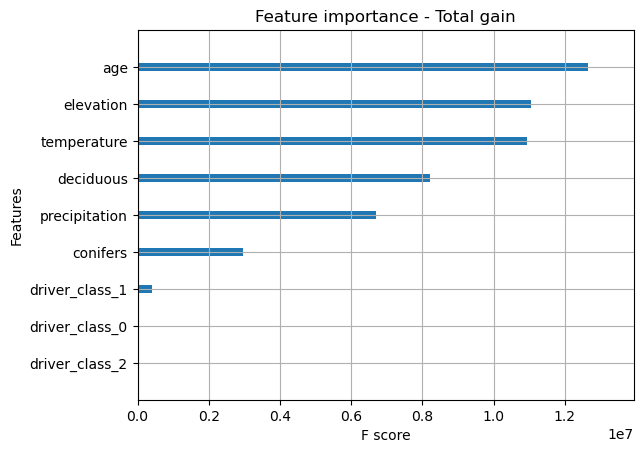

In [101]:
# Plot, metric: total gain
xgb.plot_importance(model_m2c, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance - Total gain', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='total_gain', max_num_features=10, grid=True, show_values=False)

plt.show()

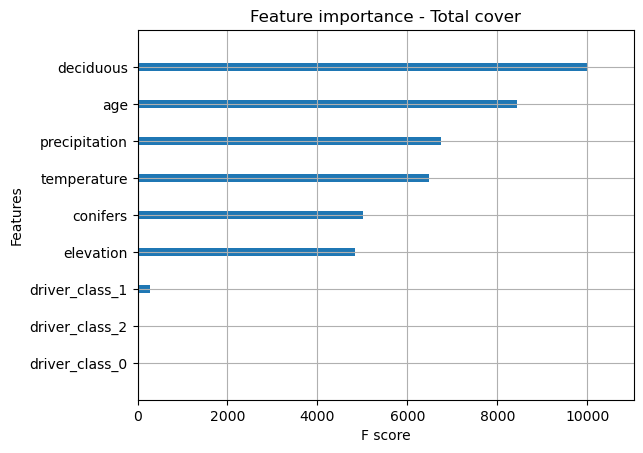

In [102]:
# Plot, metric: total cover
xgb.plot_importance(model_m2c, ax=None, height=0.2, xlim=None, ylim=None, title='Feature importance - Total cover', 
                    xlabel='F score', ylabel='Features', 
                    importance_type='total_cover', max_num_features=10, grid=True, show_values=False)

plt.show()

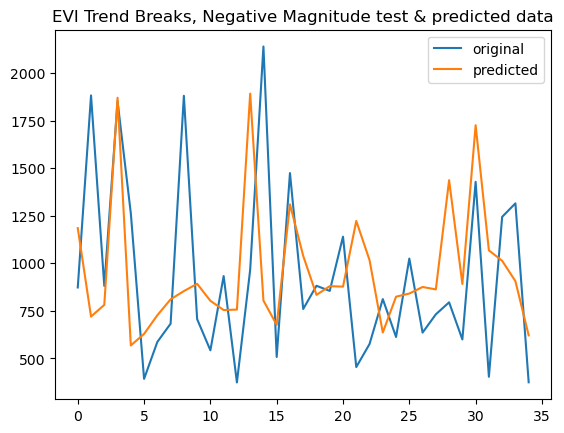

In [16]:
import matplotlib.pyplot as plt

x_ax = range(len(y1_test))
plt.plot(x_ax, y1_test, label="original")
plt.plot(x_ax, ypred, label="predicted")

plt.title("EVI Trend Breaks, Negative Magnitude test & predicted data")

plt.legend()
plt.show()

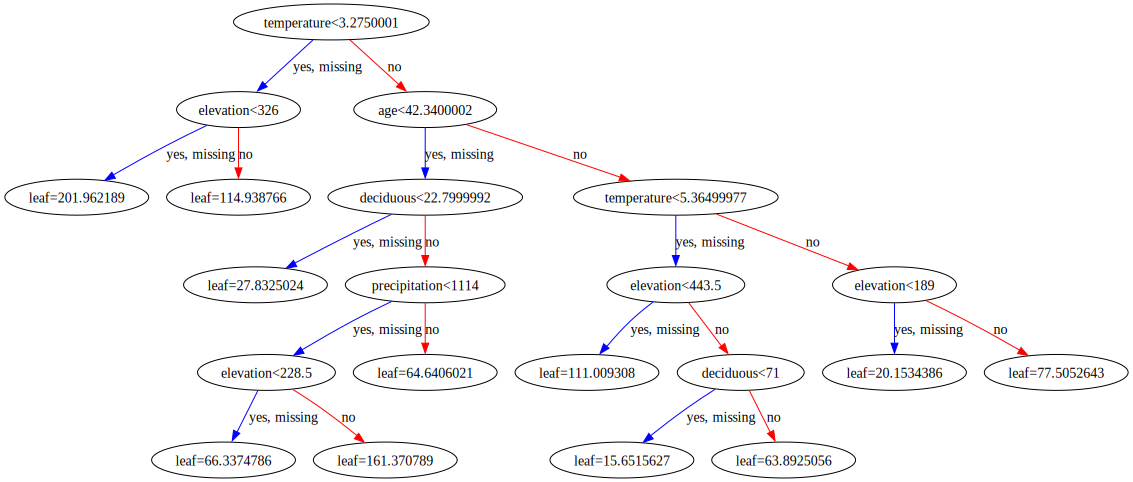

In [52]:
# Plot tree. (Note: package can't be loaded). Use rankdir='LR' to make the plot show sideways
import graphviz

#fig, ax = plt.subplots(figsize=(8, 6)) #plt.figure(2, figsize=(8, 6))
#xgb.plot_tree(model, num_trees=4)

xgb.to_graphviz(model_m2c, num_trees = 1)


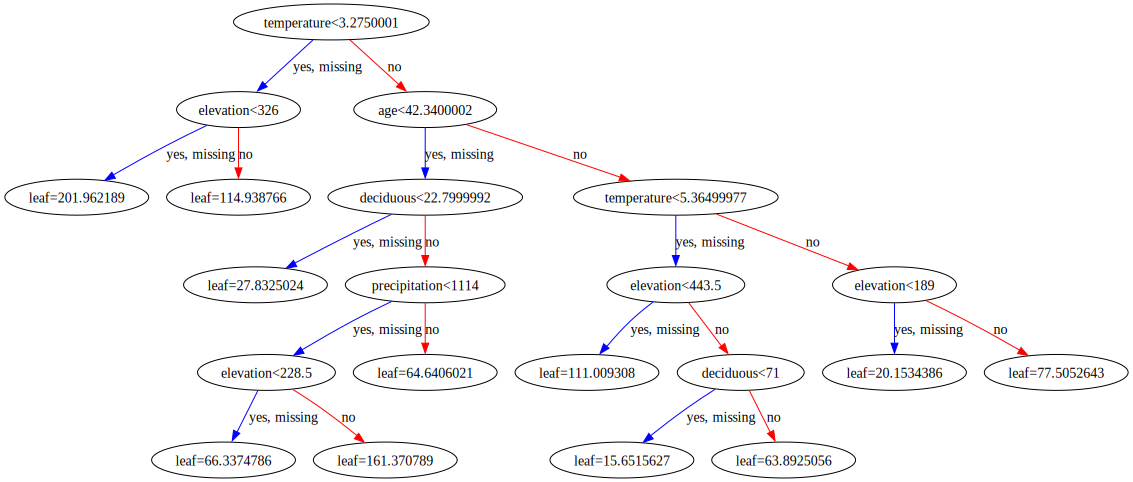

In [49]:
# Plot tree
xgb.to_graphviz(model_m2c, num_trees = 1)

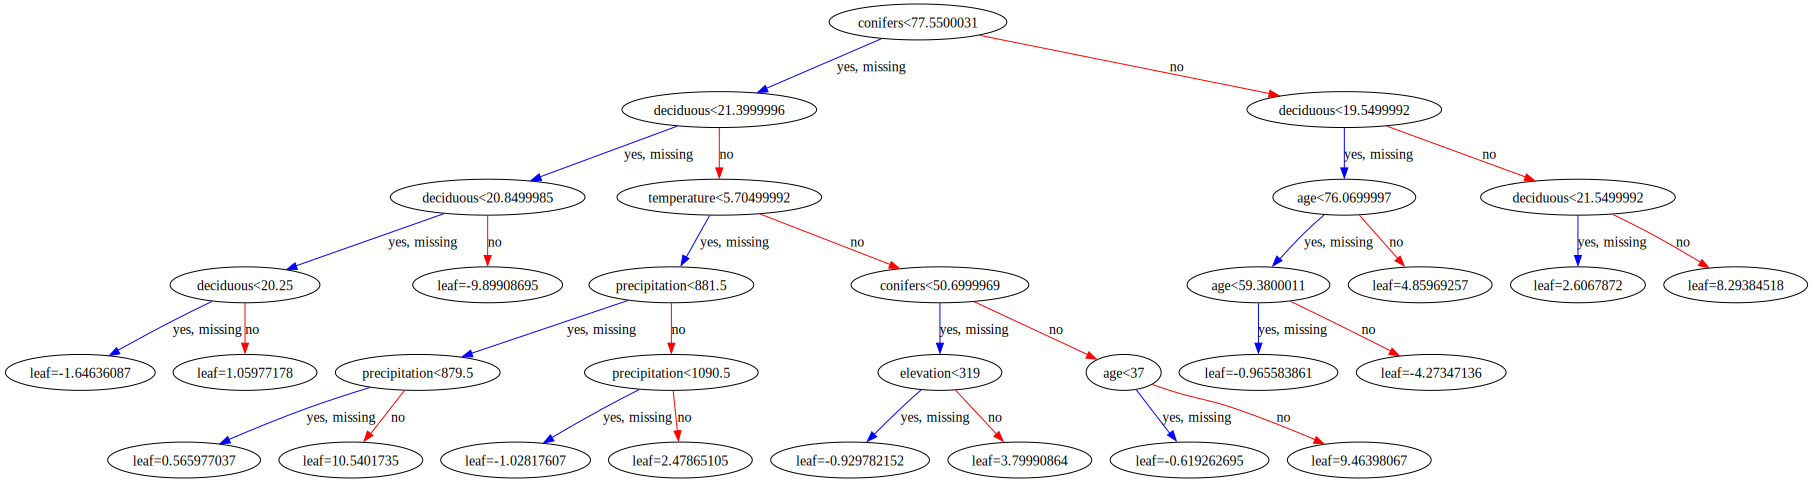

In [53]:
xgb.to_graphviz(model_m2c, num_trees = model_m2c.best_iteration) #num_trees=xgb_model.best_iteration


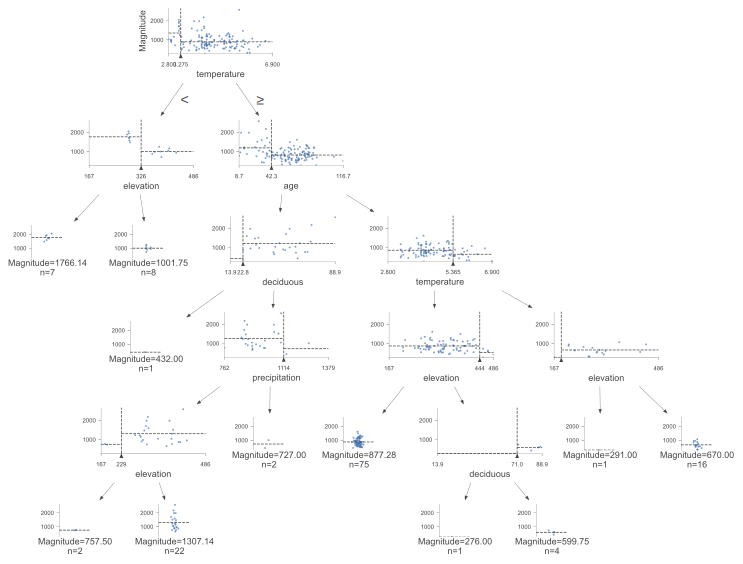

In [48]:
# More plots
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

features_names1 = ["age",  "deciduous" , "conifers" , "elevation", "precipitation" , "temperature", "protected_0",  "driver_class_0" , "driver_class_1" , "driver_class_2"]
target_names1 = "Magnitude"

# tree max is 61 after "stop early"
viz_rmodel = dtreeviz.model(model=model_m2c, tree_index=1, 
                            X_train=x1_train, 
                            y_train=y1_train, 
                            feature_names=features_names1, 
                            target_name=target_names1)

viz_rmodel.view()



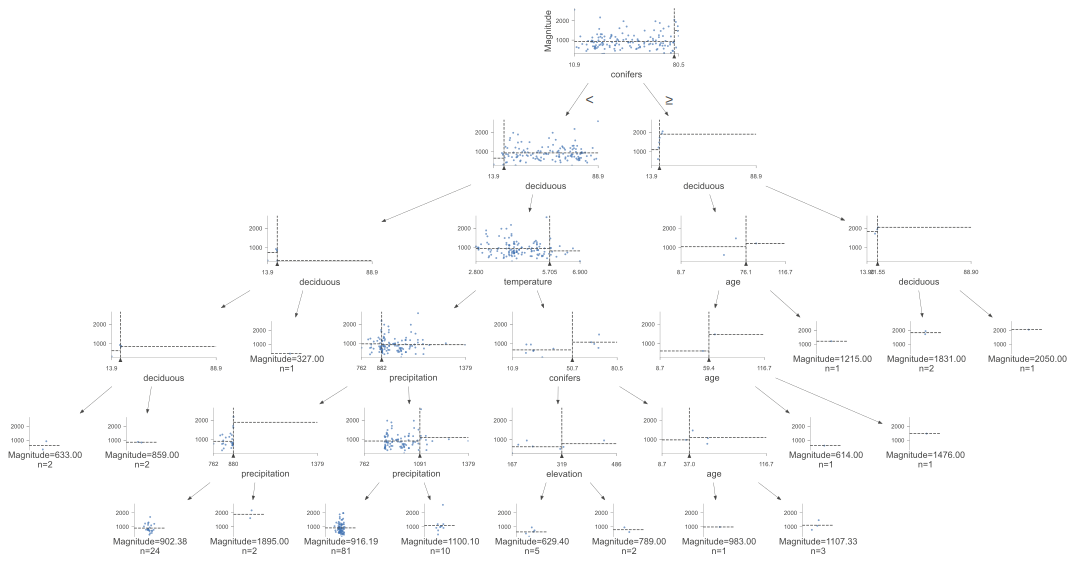

In [54]:
# More plots
import xgboost as xgb
from xgboost import plot_importance, plot_tree, plotting

import dtreeviz # To install dtreeviz see: https://github.com/parrt/dtreeviz
import graphviz
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams

#import pandas as pd
#import numpy as np

features_names1 = ["age",  "deciduous" , "conifers" , "elevation", "precipitation" , "temperature", "protected_0",  "driver_class_0" , "driver_class_1" , "driver_class_2"]
target_names1 = "Magnitude"

# tree max is 61 after "stop early"
viz_rmodel = dtreeviz.model(model=model_m2c, tree_index=model_m2c.best_iteration, 
                            X_train=x1_train, 
                            y_train=y1_train, 
                            feature_names=features_names1, 
                            target_name=target_names1)

viz_rmodel.view()



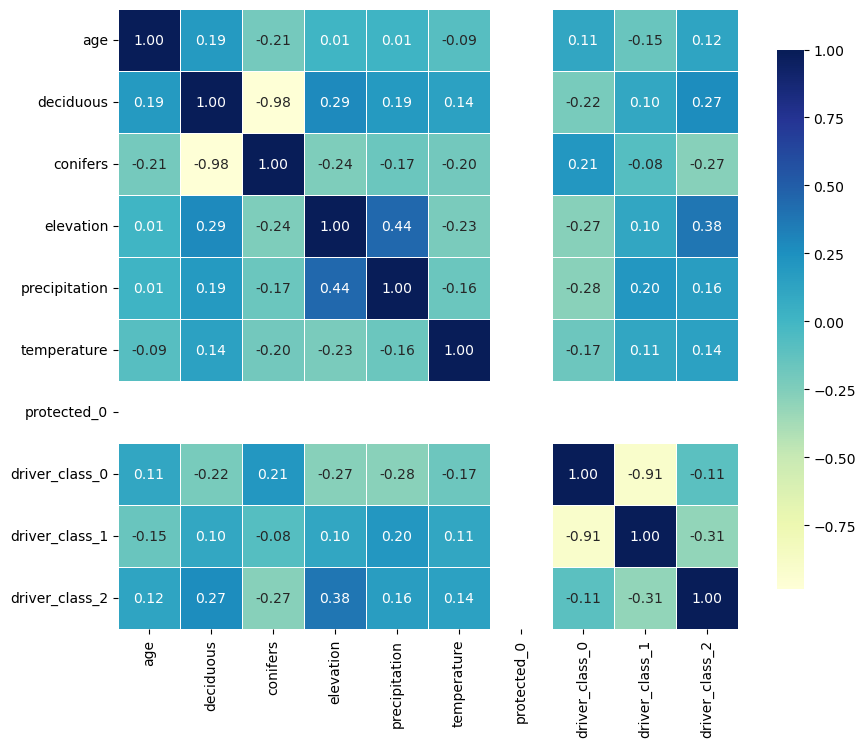

In [59]:
import seaborn as sns

def correlation_heatmap(x1_train):
    correlations = x1_train.corr()

    fig, ax = plt.subplots(figsize=(10,10))
    sns.heatmap(correlations, vmax=1.0, center=0, fmt='.2f', cmap="YlGnBu",
                square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .70}
                )
    plt.show();
    
correlation_heatmap(x1_train[features_names1])
# sorted_idx = xgb.feature_importances_.argsort()


In [18]:
# save in JSON format
#model.save_model("model_regression1.json")
# save in text format
#model_m2.save_model("model_m2.txt")


In [ ]:
# load saved model
#model2 = xgb.Regressor()
#model2.load_model("model_regression1.json")


#### References

Mostly tutorials & blogs.

https://www.youtube.com/watch?v=OQKQHNCVf5k

https://www.youtube.com/watch?v=GrJP9FLV3FE&t=2167s

https://datascience.stackexchange.com/questions/16342/unbalanced-multiclass-data-with-xgboost

https://mljar.com/blog/xgboost-save-load-python/

https://machinelearningmastery.com/xgboost-for-regression/

https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html

https://www.datatechnotes.com/2019/06/regression-example-with-xgbregressor-in.html

https://github.com/parrt/dtreeviz

https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost

https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7



